In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
try:
  import lime
except:
  !pip install lime
  import lime
try:
  import missingno
except:
  !pip install missingno
  import missingno

import missingno as msno
import pickle
import pandas as pd
import numpy as np
import sklearn.ensemble
import sklearn.model_selection
from sklearn.metrics import mean_squared_error
import lime
import lime.lime_tabular

In [3]:
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_columns', None)  

# Load Data

In [4]:
with open('/content/drive/MyDrive/skc_color/data/pi_0_317567.pkl', 'rb') as file:
  data = pickle.load(file)[0]
data.shape

(60500, 465)

In [5]:
data.type2.unique()

array(['CTF41', 'TTP41', 'CTF46'], dtype=object)

In [6]:
variables = pd.read_excel('/content/drive/MyDrive/skc_color/data/PI_stat_0407.xlsx',
                           sheet_name='tag list')
variables = variables.loc[(variables['Biz.중요도'] == '상')]
variables.head()

Date  idx column 구분 분석 대상     구분             variable tag 구분 gubun  \
2  210209   48   numeric     o  JCP02  JCP02_CA758012H.CPV    CPV  ES10   
3  210209   71   numeric     o  JCP02    JCP02_FC754022.PV     PV  ES10   
4  210209   75   numeric     o  JCP02    JCP02_FC754032.PV     PV  ES10   
7  210209  125   numeric     o  JCP02    JCP02_LC751012.PV     PV  ES10   
9  210209  135   numeric     o  JCP02    JCP02_LC757012.PV     PV  ES10   

                             Description Biz.중요도 Control_가능여부   비고  
2              MGP-2 Monomer Capacity-Hr       상            無  NaN  
3      JCP-2 ED-10-2 상부 WPR유량 Control PV       상            有  NaN  
4  EDP-10-2 (A/B) → ESRB-2 유량 Control PV       상            有  NaN  
7      ES-10-2 Level Control (Radiation)       상            有  NaN  
9                 WCT-2 Level Control PV       상            有  NaN

In [7]:
var_list = variables.variable.to_list() # 103개

# Cleaning Data

In [13]:
# Select rows which do not have NaN value in column 'Col_b'
df = data[~data['Col_b'].isnull()]
# drop unnecessary columns
df = df.drop(columns=['시험종류', '시험상태', 'expt_train', 'expt_pred'])
# Select TTP41 type 
df = df.loc[(df['type2'] == 'TTP41') & (df['타입'] == 'TTP41')]
df.head()

TIME JCP02_MO711032.PV JCP02_MO758012.PV  \
3216 2020-01-19 22:00:00               2.0               2.0   
3228 2020-01-19 23:00:00               2.0               2.0   
3240 2020-01-20 00:00:00               2.0               2.0   
3252 2020-01-20 01:00:00               2.0               2.0   
3264 2020-01-20 02:00:00               2.0               2.0   

     JCP02_MO762012.PV JCP02_VA753012.PV JCP02_VA769112.PV JCP02_VA769132.PV  \
3216               2.0               2.0               0.0               2.0   
3228               2.0               2.0               0.0               2.0   
3240               2.0               2.0               0.0               2.0   
3252               2.0               2.0               0.0               2.0   
3264               2.0               2.0               0.0               2.0   

     JCP02_VA769222.PV JCP02_VA769122.PV JCP02_VA769212.PV  ...  \
3216               2.0               0.0               2.0  ...   
3228               2.0               0.0               2.0  ...   
3240               2.0               0.0               2.0  ...   
3252               2.0               0.0               2.0  ...   
3264               2.0               0.0               2.0  ...   

     JCP02_WI757012.CPV JCP02_WI765062.CPV  JCP02_WI765072.CPV  \
3216           5.585981           4.082253            4.445421   
3228           5.595999           4.080661            4.444611   
3240           5.595314           4.090028            4.461153   
3252           5.590688           4.106674            4.478567   
3264           5.594737           4.106286            4.481059   

      JCP02_WI766012.CPV  JCP02_WI766022.CPV  JCP02_XI767012.PV  Col_b     타입  \
3216            1.831885            4.608244            43.4265    4.5  TTP41   
3228            1.827434            4.608731            43.0394    4.4  TTP41   
3240            1.833694            4.609189            42.7147    4.4  TTP41   
3252            1.827569            4.608055            43.2421    4.4  TTP41   
3264            1.827689            4.608733            42.4474    4.4  TTP41   

        SMT3  type2  
3216  7.6479  TTP41  
3228  6.6255  TTP41  
3240  3.0631  TTP41  
3252   3.281  TTP41  
3264  3.8305  TTP41  

[5 rows x 461 columns]

In [14]:
len(df)

211

## handling missing values

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53440 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51077 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 53440 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51077 missing from current font.
  font.set_text(s, 0, flags=flags)


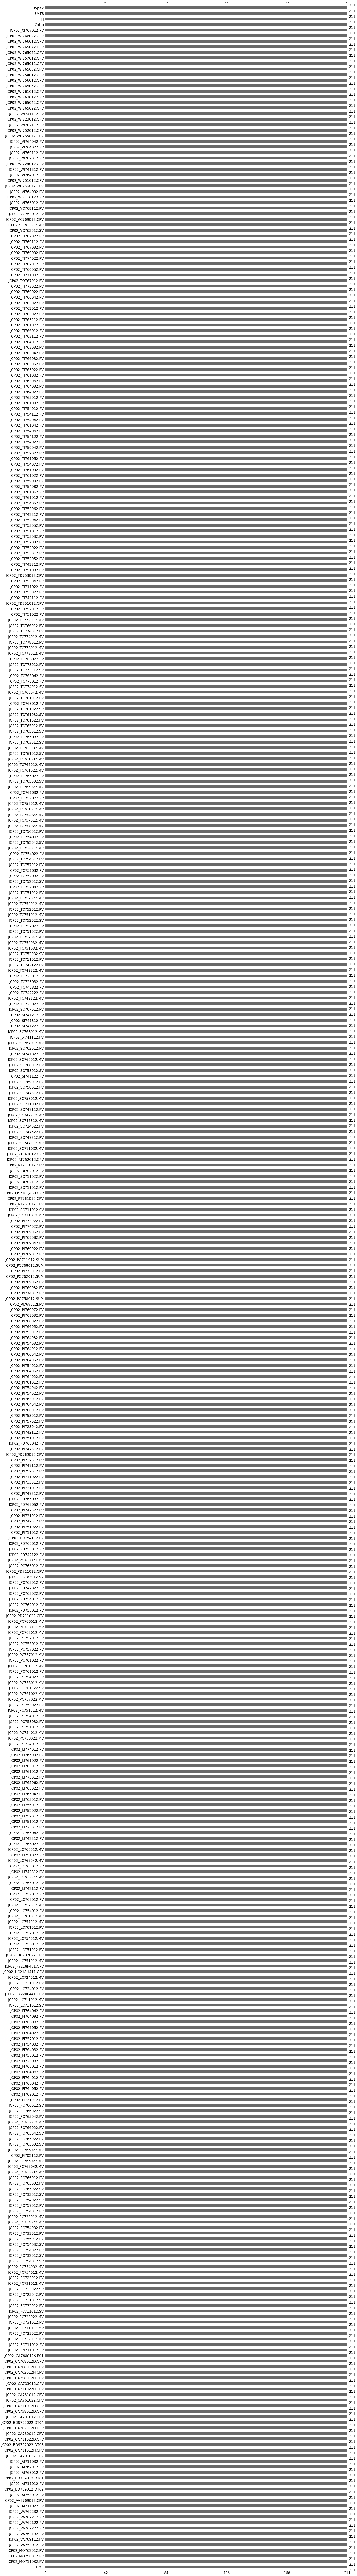

In [7]:
# msno.matrix(df)
msno.bar(df)

In [15]:
df = df.fillna(df.mean())
df.isnull().sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


TIME                 0
JCP02_MO711032.PV    0
JCP02_MO758012.PV    0
JCP02_MO762012.PV    0
JCP02_VA753012.PV    0
                    ..
JCP02_XI767012.PV    0
Col_b                0
타입                   0
SMT3                 0
type2                0
Length: 461, dtype: int64

# Select features and Split Data

In [16]:
#x = df[['JCP02_CA758012H.CPV','JCP02_FC754022.PV','JCP02_FC754032.PV','JCP02_LC751012.PV','JCP02_LC757012.PV','JCP02_LI751022.PV', 'JCP02_PI754042.PV', 'JCP02_TC751012.PV', 'JCP02_TC751022.PV', 'JCP02_TC751032.PV']]
x = df[var_list]
y = df["Col_b"]

In [18]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, train_size=0.80, test_size=0.20)

# Fit Random Forest Regression Model

In [19]:
rf = sklearn.ensemble.RandomForestRegressor(n_estimators=1000)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000)

In [21]:
y_pred = rf.predict(X_test)

# Evaluate Performance


In [39]:
print('Random Forest MSError', np.mean((rf.predict(X_test) - y_test) ** 2))
print('MSError when predicting the mean', np.mean((y_train.mean() - y_test) ** 2))

Random Forest MSError 0.02489186372093108
MSError when predicting the mean 0.15926524679639298


In [22]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)**(0.5)
mse

0.15777155548745495

# Apply Lime

In [23]:
import lime
import lime.lime_tabular

In [ ]:
X_train.columns.values.tolist()

In [25]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                   feature_names=X_train.columns.values.tolist(), 
                                                   class_names=["Col_b"], 
                                                  #  categorical_features=categorical_features, 
                                                   verbose=True, 
                                                   mode='regression')

In [36]:
# Choose the 5th instance and use it to predict the results
j = 2
exp = explainer.explain_instance(X_test.values[j], rf.predict, num_features=10)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"


Intercept 3.224034073788126
Prediction_local [3.45520811]
Right: 3.781600000000026


In [37]:
# Show the predictions
exp.show_in_notebook(show_table=True)

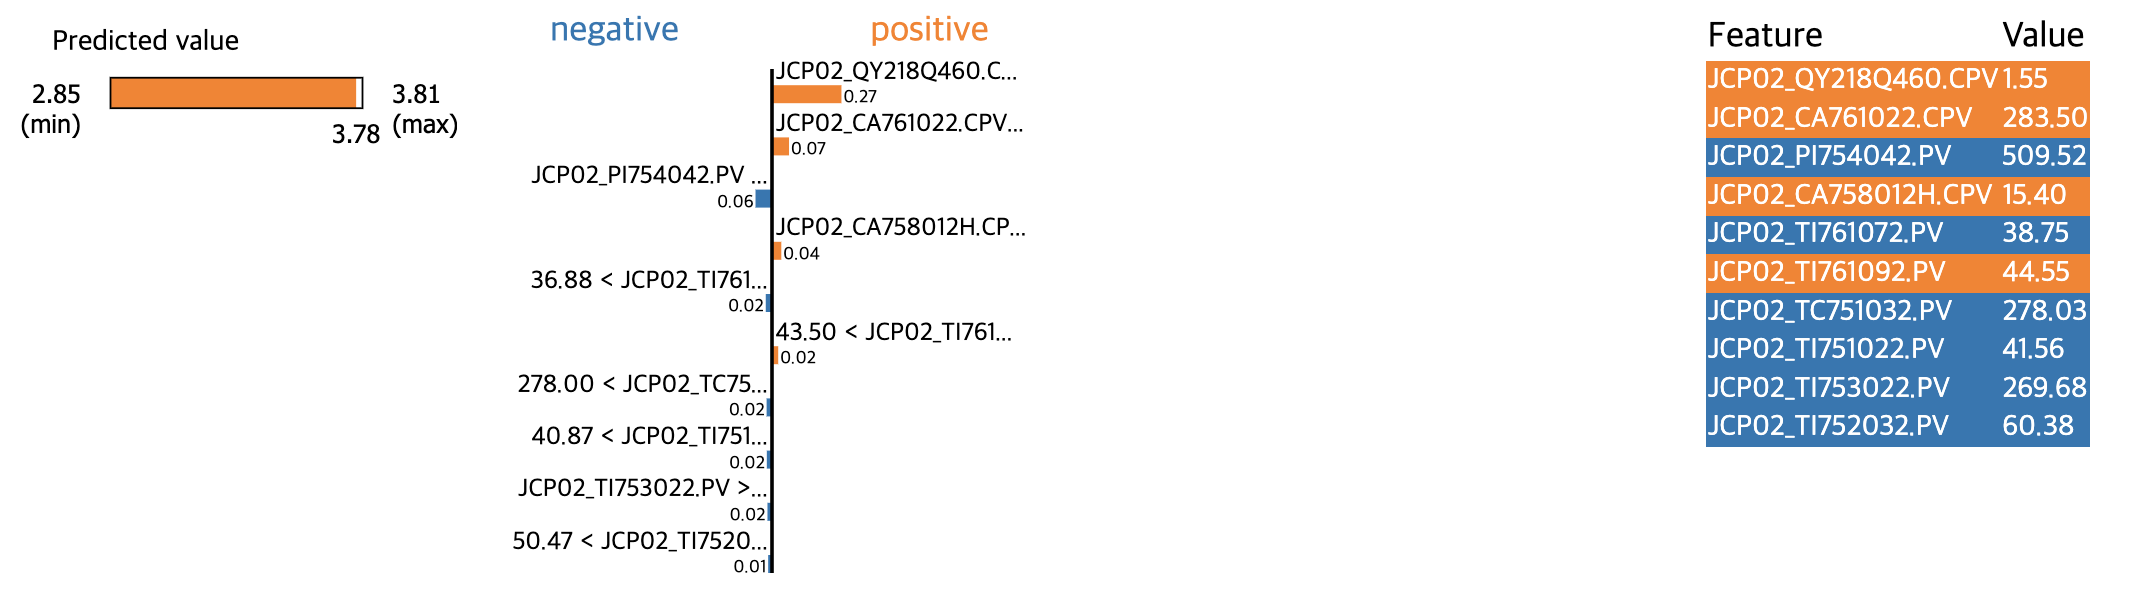

### 케이스에 대한 LIME 해석 의견

- 왼쪽 패널 ▶ Random Forest Model 은 "3.78" 일 거라고 예측했다. 따라서 컬러는 높을수록 파랗다고 했기 때문에 (?) 실제 결과산출물은 파란색에 가깝나?!

 - 중앙 패널 ▶ 특정 데이터 포인트의 각각의 feature 를 통해 (중요도순) 예측을 설명하고자 한다

     - 이 케이스(instance sample)의 예측값을 가장 강하게 서포트 하는 feature는 `'JCP02_QY218Q460.CPV > 1.54'` 에 해당되는 경우인데, 1.55 값을 지니고 있는 `Paste Mole Ratio` 라고 하니, 컬러 반죽 비율/원료 배합 비율을 의미하는 것으로 추정 --> 그런 의미라면, 꽤 significant feature 라고 받아들여지므로 lime이 feature를 잘 가져와 해석하고 있는 듯

   - 같은 원리로 이 샘플 `'JCP02_CA761022.CPV > 282.94'` 에 해당하기 때문에, 예측값에 힘을 더 실어주고 있다. Desc.에 `Jack-O Temp Calc` 라는 것으로 보아, 롤 자체를 발열시켜 온도 분포를 균일하게 하는 히팅롤 (jacket roll)의 온도를 뜻하는 것으로 추정. 이 외에도 각 공정별 온도를 뜻하는 변수들이 많기 때문에 make sense

   - 반대로 이 샘플의 예측을 부정적으로 설명하는 변수도 있다. 509.52 값을 가져 `'JCP02_PI754042.PV <= 510.03'` 에 해당되는데, `EC-10-2 → WCT-2 압력` 라는 것으로 보아 설비 기기간 압력량을 의미하는 것으로 추정

- 오른쪽 패널 ▶ 이 샘플의 features & values 를 나타낸다

In [38]:
exp.as_list()

[('JCP02_QY218Q460.CPV > 1.54', 0.26605564695314854),
 ('JCP02_CA761022.CPV > 282.94', 0.0652295160861877),
 ('JCP02_PI754042.PV <= 510.03', -0.0631340099007638),
 ('JCP02_CA758012H.CPV > 15.26', 0.035643043353364386),
 ('36.88 < JCP02_TI761072.PV <= 39.22', -0.023886004355790556),
 ('43.50 < JCP02_TI761092.PV <= 47.29', 0.023770999886714037),
 ('278.00 < JCP02_TC751032.PV <= 278.06', -0.02063640436513077),
 ('40.87 < JCP02_TI751022.PV <= 42.96', -0.019822725735721924),
 ('JCP02_TI753022.PV > 269.55', -0.017367249338537984),
 ('50.47 < JCP02_TI752032.PV <= 110.21', -0.014678778154233577)]

# CTP 41 실험

In [8]:
# Select rows which do not have NaN value in column 'Col_b'
df_CTF41 = data[~data['Col_b'].isnull()]
# drop unnecessary columns
df_CTF41 = df_CTF41.drop(columns=['시험종류', '시험상태', 'expt_train', 'expt_pred'])
# Select CTF41 type 
df_CTF41 = df_CTF41.loc[(df_CTF41['type2'] == 'CTF41') & (df_CTF41['타입'] == 'CTF41')]
df_CTF41.head()

TIME JCP02_MO711032.PV JCP02_MO758012.PV JCP02_MO762012.PV  \
576 2020-01-10 18:00:00               2.0               2.0               2.0   
588 2020-01-10 19:00:00               2.0               2.0               2.0   
600 2020-01-10 20:00:00               2.0               2.0               2.0   
612 2020-01-10 21:00:00               2.0               2.0               2.0   
624 2020-01-10 22:00:00               2.0               2.0               2.0   

    JCP02_VA753012.PV JCP02_VA769112.PV JCP02_VA769132.PV JCP02_VA769222.PV  \
576               2.0               2.0               2.0               0.0   
588               2.0               2.0               2.0               0.0   
600               2.0               2.0               2.0               0.0   
612               2.0               2.0               2.0               0.0   
624               2.0               2.0               2.0               0.0   

    JCP02_VA769122.PV JCP02_VA769212.PV  ... JCP02_WI757012.CPV  \
576               2.0               0.0  ...           5.601008   
588               2.0               0.0  ...           5.593783   
600               2.0               0.0  ...           5.592864   
612               2.0               0.0  ...           5.593874   
624               2.0               0.0  ...           5.595432   

    JCP02_WI765062.CPV  JCP02_WI765072.CPV  JCP02_WI766012.CPV  \
576           4.092347            4.467299            1.828175   
588           4.093405            4.467539            1.828543   
600           4.093731            4.467899            1.825333   
612           4.093032            4.467477            1.832394   
624           4.092709            4.467615            1.830949   

     JCP02_WI766022.CPV  JCP02_XI767012.PV  Col_b     타입    SMT3  type2  
576            4.608222            44.1957    6.1  CTF41 -1.4095  CTF41  
588            4.608338            43.8762    5.7  CTF41 -1.0863  CTF41  
600            4.608630            43.8196    5.7  CTF41 -0.9684  CTF41  
612            4.608056            44.0014    5.6  CTF41 -1.7002  CTF41  
624            4.608101            43.9590    5.3  CTF41 -1.3791  CTF41  

[5 rows x 461 columns]

In [15]:
len(df_CTF41)

877

In [10]:
x = df_CTF41[var_list]
y = df_CTF41["Col_b"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, train_size=0.80, test_size=0.20)

In [11]:
rf = sklearn.ensemble.RandomForestRegressor(n_estimators=1000)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000)

In [12]:
y_pred = rf.predict(X_test)

# Evaluate Performance


In [13]:
print('Random Forest MSError', np.mean((rf.predict(X_test) - y_test) ** 2))
print('MSError when predicting the mean', np.mean((y_train.mean() - y_test) ** 2))

Random Forest MSError 0.17558343875000196
MSError when predicting the mean 0.7440035459375803


In [14]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)**(0.5)
mse

0.41902677569578056

# Apply Lime

In [16]:
import lime
import lime.lime_tabular

In [ ]:
X_train.columns.values.tolist()

In [18]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                   feature_names=X_train.columns.values.tolist(), 
                                                   class_names=["Col_b"], 
                                                  #  categorical_features=categorical_features, 
                                                   verbose=True, 
                                                   mode='regression')

In [19]:
# Choose the 5th instance and use it to predict the results
j = 2
exp = explainer.explain_instance(X_test.values[j], rf.predict, num_features=10)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"


Intercept 4.34579396213266
Prediction_local [3.77230987]
Right: 3.6207999999999956


In [20]:
# Show the predictions
exp.show_in_notebook(show_table=True)

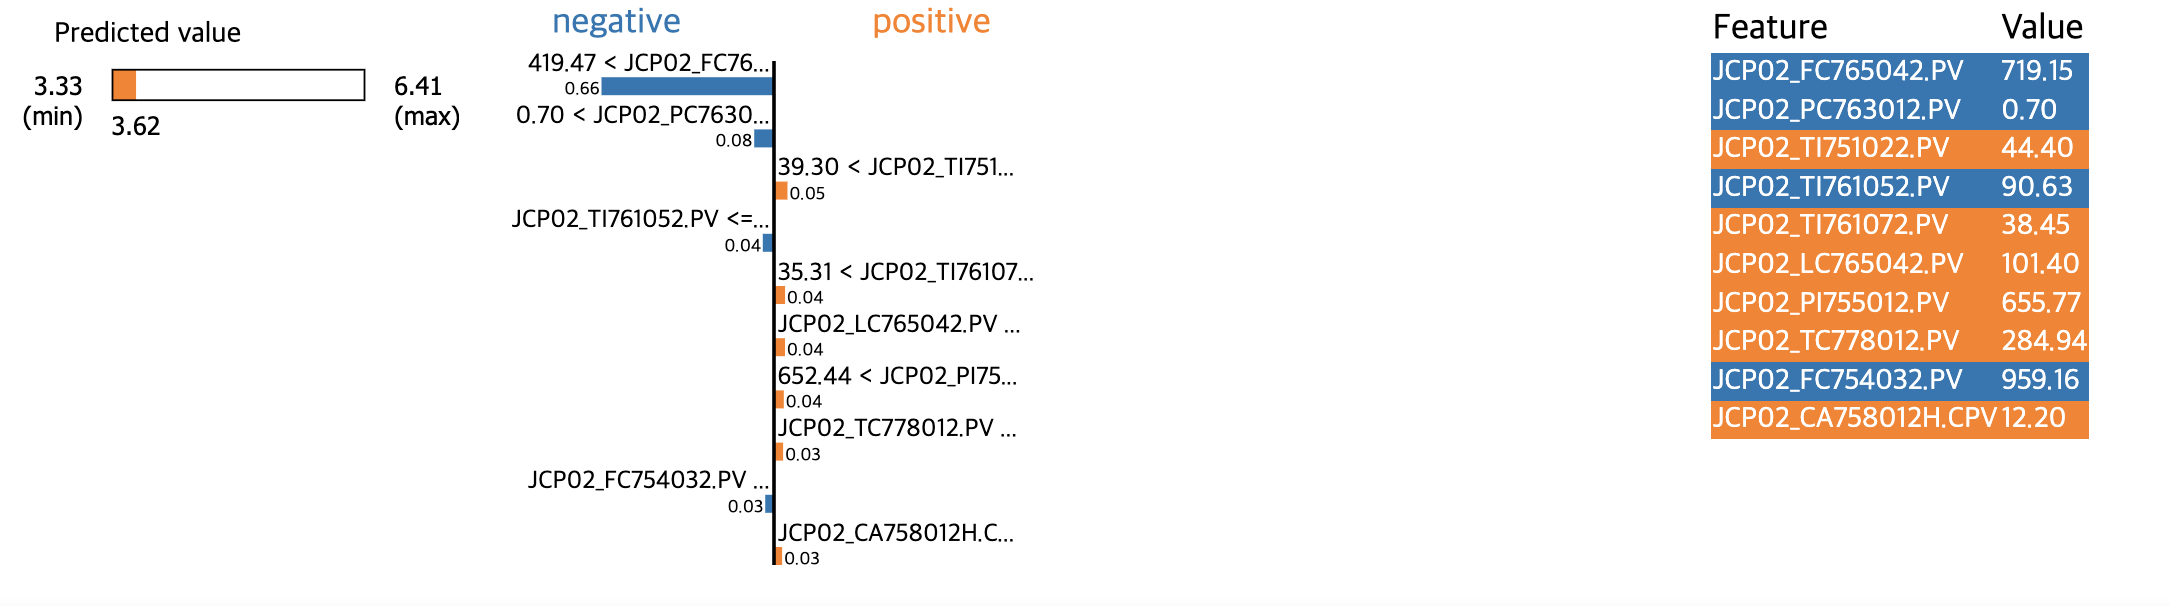

In [21]:
exp.as_list()

[('419.47 < JCP02_FC765042.PV <= 720.83', -0.6609257131683991),
 ('0.70 < JCP02_PC763012.PV <= 0.75', -0.07575353162385305),
 ('39.30 < JCP02_TI751022.PV <= 45.09', 0.051611589503177305),
 ('JCP02_TI761052.PV <= 138.28', -0.04295139580817898),
 ('35.31 < JCP02_TI761072.PV <= 43.11', 0.042400138869101066),
 ('JCP02_LC765042.PV <= 101.82', 0.042243332622002805),
 ('652.44 < JCP02_PI755012.PV <= 657.79', 0.03755945798317279),
 ('JCP02_TC778012.PV <= 284.98', 0.034889451692605405),
 ('JCP02_FC754032.PV <= 984.23', -0.033582218622743666),
 ('JCP02_CA758012H.CPV <= 12.45', 0.031024796358258163)]